In [2]:
%matplotlib inline
import pylab
import numpy as np
import nengo
import nengo.spa as spa


In [125]:
dimensions = 10
input_scale = 1
n_neurons_per_dim = 50
intercept_low = -0.5
intercept_high = 1.0
tau_input = 0.01
tau_recurrent = 0.1
tau_reset = 0.2
max_rate_high = 200
max_rate_low = 150
sensory_delay = 0.05
reset_scale = 0.3

model = nengo.Network()
with model:
    vocab = spa.Vocabulary(dimensions)
    value = vocab.parse('A').v
    
    def stim(t):
        if 0.5 < t - sensory_delay < 0.75:
            return value
        else:
            return [0]*dimensions
    stim = nengo.Node(stim)
    
    a = nengo.Ensemble(n_neurons=n_neurons_per_dim * dimensions,
                       dimensions=dimensions,
                       max_rates=nengo.dists.Uniform(max_rate_low, max_rate_high),
                       intercepts=nengo.dists.Uniform(intercept_low, intercept_high))
    
    b = nengo.Ensemble(n_neurons=n_neurons_per_dim * dimensions,
                       dimensions=dimensions,
                       max_rates=nengo.dists.Uniform(max_rate_low, max_rate_high),
                       intercepts=nengo.dists.Uniform(intercept_low, intercept_high))
    
    nengo.Connection(stim, a, synapse=None)
    nengo.Connection(a, b, synapse=tau_input, transform=input_scale)
    nengo.Connection(b, b, synapse=tau_recurrent)
    
    def reset(t):
        if t - sensory_delay > 1.75:
            return 1
        else:
            return 0
    reset_stim = nengo.Node(reset)
    reset_value = vocab.parse('B').v
    reset_value.shape = dimensions, 1
    nengo.Connection(reset_stim, b.neurons, transform=np.ones((b.n_neurons, 1))*-reset_scale, synapse=tau_reset)
    #nengo.Connection(reset_stim, b, transform=reset_value*reset_scale, synapse=tau_reset)
    
    p_value = nengo.Probe(b, synapse=0.01)
    p_neurons = nengo.Probe(b.neurons)

In [126]:
sim = nengo.Simulator(model)
sim.run(2.5)

Simulation finished in 0:00:05.                                                 


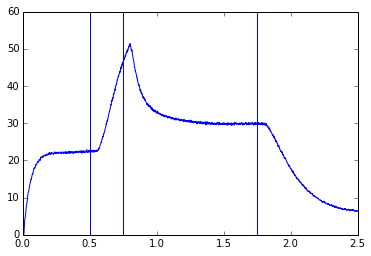

In [127]:
rates = sim.data[p_neurons]
ratesf = nengo.synapses.Lowpass(0.05).filt(rates)

pylab.plot(sim.trange(), np.mean(ratesf, axis=1))
pylab.axvline(0.5)
pylab.axvline(0.75)
pylab.axvline(1.75)
pylab.show()

N= 246


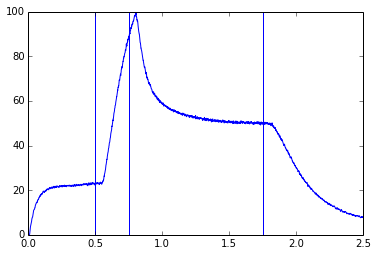

In [136]:
encs = sim.data[b].encoders
similarity = np.dot(encs, value)
items = np.where(similarity>0.0)   # TODO: What is this threshold in the real data?
print 'N= %d' % len(items[0])
pylab.plot(sim.trange(), np.mean(ratesf[:,items[0]], axis=1))
pylab.axvline(0.5)
pylab.axvline(0.75)
pylab.axvline(1.75)
pylab.show()